### Исследование зависимости длины шага от его ширины

In [1]:
import os
import pandas as pd
import numpy as np
from scipy import stats
import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')

import plotly.plotly as py
import plotly.graph_objs as go

In [2]:
pd.options.mode.chained_assignment = None

Read in all data

In [3]:
data_path = '../output/parsed_data/'
flnms = os.listdir(data_path)

df = pd.DataFrame()

for fl in flnms:
    d = pd.read_csv(data_path + fl)
    d = d[d['frame'] > 10]
    df = pd.concat([df, d])

In [4]:
bad_amc = ['32_01.amc', '32_02.amc']
df = df[~df['amc_path'].isin(bad_amc)]

In [5]:
# ось 0 - по ширине шага, 2 - по направлению движения
cols = [
    'ltibia_norm_coord_0',
    'rtibia_norm_coord_0',
    'ltibia_norm_coord_2',
    'rtibia_norm_coord_2',
    'frame',
    'amc_path',
    'phases_l',
    'phases_r',
    'support'
]

In [6]:
df_data = df[cols]

In [7]:
df_data.shape

(24685, 9)

In [8]:
def dm_to_sm(a):
    b = a / 0.45 * 2.54
    return b

## перевод в см
df_data.loc[:, 'ltibia_norm_coord_0'] = df_data.loc[:, 'ltibia_norm_coord_0'].apply(dm_to_sm)
df_data.loc[:, 'rtibia_norm_coord_0'] = df_data.loc[:, 'rtibia_norm_coord_0'].apply(dm_to_sm)
df_data.loc[:, 'ltibia_norm_coord_2'] = df_data.loc[:, 'ltibia_norm_coord_2'].apply(dm_to_sm)
df_data.loc[:, 'rtibia_norm_coord_2'] = df_data.loc[:, 'rtibia_norm_coord_2'].apply(dm_to_sm)

In [9]:
df_data.head()

,ltibia_norm_coord_0,rtibia_norm_coord_0,ltibia_norm_coord_2,rtibia_norm_coord_2,frame,amc_path,phases_l,phases_r,support
11,-2.391325,2.224104,24.758995,-32.632263,11,02_01.amc,heel_strike,toe_off,ds
12,-2.287779,1.960920,23.929545,-33.002823,12,02_01.amc,heel_strike,toe_off,ds
13,-2.190264,1.729526,23.028429,-33.366253,13,02_01.amc,NaN,toe_off,ds
14,-2.100436,1.495333,22.129483,-33.698610,14,02_01.amc,NaN,toe_off,ds
15,-2.078251,1.175375,21.267262,-33.922674,15,02_01.amc,NaN,toe_off,ds


In [10]:
df_data['width'] = abs(df_data['ltibia_norm_coord_0'] - df_data['rtibia_norm_coord_0'])

Будем рассматривать шаг как цикл от правой ноги

Сначала для каждого файла:
- сделаем разметку номером шага
- посчитаем для каждого шага длину и среднюю ширину шага
- агрегируем для одного файла. Так как циклы могут быть неполными, то если количество шагов менее 3, откидываем, иначе считаем медианную длину и ширину шага

Далее будем смотреть статистики по всем файлам

Для одного файла движения

In [34]:
amc_data = df_data[df_data['amc_path'] == '02_01.amc']

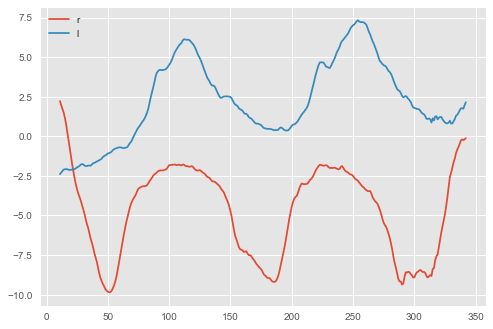

In [35]:
plt.plot(amc_data.frame, 
         amc_data.rtibia_norm_coord_0, label="r")
plt.plot(amc_data.frame, 
         amc_data.ltibia_norm_coord_0, label="l")
plt.legend(loc=2);

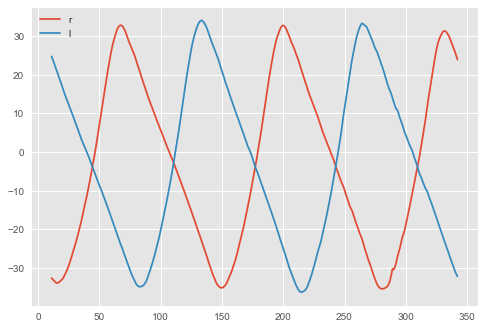

In [36]:
plt.plot(amc_data.frame, 
         amc_data.rtibia_norm_coord_2, label="r")
plt.plot(amc_data.frame, 
         amc_data.ltibia_norm_coord_2, label="l")
plt.legend(loc=2);

In [37]:
# определяем перегиб как совпадение знака разности текущей точки с предыдущей и следующей по 2 точкам
col = 'rtibia_norm_coord_2'
amc_data['shift_1'] = amc_data[col].shift(1)
amc_data['shift_-1'] = amc_data[col].shift(-1)
amc_data['diff_1'] = amc_data[col] - amc_data['shift_1']
amc_data['diff_-1'] = amc_data[col] - amc_data['shift_-1']
amc_data['sign_-1'] = amc_data['diff_-1'].apply(lambda x: 1 if x > 0 else -1)
amc_data['sign_1'] = amc_data['diff_1'].apply(lambda x: 1 if x > 0 else -1)

amc_data['shift_2'] = amc_data[col].shift(2)
amc_data['shift_-2'] = amc_data[col].shift(-2)
amc_data['diff_2'] = amc_data[col] - amc_data['shift_2']
amc_data['diff_-2'] = amc_data[col] - amc_data['shift_-2']
amc_data['sign_-2'] = amc_data['diff_-2'].apply(lambda x: 1 if x > 0 else -1)
amc_data['sign_2'] = amc_data['diff_2'].apply(lambda x: 1 if x > 0 else -1)

amc_data['sign'] = 0
amc_data.loc[
    (amc_data['sign_1'] == amc_data['sign_-1']) &
    (amc_data['sign_2'] == amc_data['sign_-2'])
    , 'sign'] = 1


In [38]:
amc_data[amc_data['sign'] == 1]

,ltibia_norm_coord_0,rtibia_norm_coord_0,ltibia_norm_coord_2,rtibia_norm_coord_2,frame,amc_path,phases_l,phases_r,support,width,...,diff_-1,sign_-1,sign_1,shift_2,shift_-2,diff_2,diff_-2,sign_-2,sign_2,sign
15,-2.078251,1.175375,21.267262,-33.922674,15,02_01.amc,NaN,toe_off,ds,3.253626,...,-0.041589,-1,-1,-33.366253,-33.712666,-0.556421,-0.210008,-1,-1,1
67,-0.548200,-4.807360,-23.637259,32.824963,67,02_01.amc,NaN,NaN,lss,4.259161,...,0.011190,1,1,32.151175,32.512806,0.673788,0.312157,1,1,1
150,2.482561,-4.715435,20.850111,-35.169659,150,02_01.amc,NaN,toe_off,ds,7.197995,...,-0.173497,-1,-1,-34.954316,-34.716531,-0.215343,-0.453128,-1,-1,1
200,0.660602,-4.450356,-24.982437,32.778874,200,02_01.amc,NaN,NaN,lss,5.110958,...,0.199403,1,1,32.291259,32.099094,0.487615,0.679780,1,1,1
281,3.941822,-6.771447,21.797307,-35.392459,281,02_01.amc,heel_strike,toe_off,ds,10.713269,...,-0.049951,-1,-1,-35.299316,-35.210241,-0.093142,-0.182218,-1,-1,1
331,0.807404,-1.991409,-22.707261,31.376060,331,02_01.amc,NaN,NaN,lss,2.798813,...,0.071177,1,1,30.535197,31.084085,0.840863,0.291975,1,1,1
342,2.151540,-0.118185,-32.192089,23.963220,342,02_01.amc,toe_off,heel_strike,ds,2.269725,...,NaN,-1,-1,25.991238,NaN,-2.028018,NaN,-1,-1,1


In [39]:
# отрежем первый неполный цикл

min_cyc = amc_data[amc_data['sign'] == 1].frame.min()
amc_data = amc_data[amc_data['frame'] > min_cyc]

In [40]:
amc_data.reset_index(inplace=True, drop=True)

In [41]:
start_gate_sign = amc_data.loc[0, 'sign_-1']

In [42]:
n_gate = 0
gate_d = {}
cur_gate = []

for idx, row in amc_data.iterrows():
    if row['sign'] == 0:
        cur_gate.append(row['frame'])
    else:
        if (row['sign_-1'] == start_gate_sign) & (row['sign_-2'] == start_gate_sign):
            gate_d[n_gate] = cur_gate
            n_gate = n_gate + 1
            cur_gate = [row['frame']]
        else:
            cur_gate.append(row['frame'])

last_c = gate_d[n_gate - 1]
last_c.extend(cur_gate)
gate_d[n_gate - 1] = last_c

In [43]:
all_g = pd.DataFrame()

for key, v in gate_d.items():
    d = pd.DataFrame(gate_d[key])
    d.columns = ['frame']
    d['n_gate'] = key
    all_g = pd.concat([all_g, d], axis=0)

In [44]:
amc_data = pd.merge(amc_data, all_g, left_on='frame', right_on='frame')

In [45]:
amc_data.drop([
    'shift_1', 'shift_-1', 'shift_2', 'shift_-2',
    'diff_1', 'diff_-1', 'diff_2', 'diff_-2',
    'sign_1', 'sign_-1', 'sign_2', 'sign_-2',
    'sign'], axis=1, inplace=True)

In [46]:
amc_data

,ltibia_norm_coord_0,rtibia_norm_coord_0,ltibia_norm_coord_2,rtibia_norm_coord_2,frame,amc_path,phases_l,phases_r,support,width,n_gate
0,-2.074259,0.749974,20.354709,-33.881085,16,02_01.amc,NaN,toe_off,ds,2.824233,0
1,-2.077690,0.270869,19.426335,-33.712666,17,02_01.amc,NaN,toe_off,ds,2.348559,0
2,-2.115309,-0.247685,18.529718,-33.465078,18,02_01.amc,NaN,toe_off,ds,1.867624,0
3,-2.122489,-0.780425,17.581805,-33.146778,19,02_01.amc,NaN,toe_off,ds,1.342063,0
4,-2.111052,-1.308581,16.584470,-32.789615,20,02_01.amc,NaN,toe_off,ds,0.802472,0
5,-2.106950,-1.803808,15.641132,-32.272519,21,02_01.amc,NaN,toe_off,ds,0.303142,0
6,-2.096118,-2.265452,14.735776,-31.639110,22,02_01.amc,NaN,toe_off,ds,0.169334,0
7,-2.067499,-2.689995,13.873947,-30.978712,23,02_01.amc,NaN,toe_off,ds,0.622497,0
8,-2.008281,-3.055609,13.052081,-30.235823,24,02_01.amc,NaN,toe_off,ds,1.047328,0
9,-1.957505,-3.369639,12.220420,-29.373572,25,02_01.amc,NaN,toe_off,ds,1.412135,0


In [52]:
gates_stats = amc_data.groupby(['n_gate']).agg({'width': ['min', 'max', 'mean'], 'rtibia_norm_coord_2': ['min', 'max']})

cols = ["_".join(i) for i in gates_stats.columns.ravel()]

gates_stats.columns = cols

gates_stats['length'] = gates_stats[col + "_max"] - gates_stats[col + "_min"]

check gates >= 3


take median

In [65]:
gates_stats_final = gates_stats.median()

In [66]:
gates_stats_final

rtibia_norm_coord_2_min   -35.388258
rtibia_norm_coord_2_max    32.778874
width_min                   1.969846
width_max                  10.500041
width_mean                  8.037455
length                     67.969280
dtype: float64

Соберем данные для всех файлов

In [69]:
def get_gates_cycle(amc_data_source, col='rtibia_norm_coord_2'):
    
    amc_data = amc_data_source.copy(deep=True)
    
    # определяем перегиб как совпадение знака разности текущей точки с предыдущей и следующей по 2 точкам
    amc_data['shift_1'] = amc_data[col].shift(1)
    amc_data['shift_-1'] = amc_data[col].shift(-1)
    amc_data['diff_1'] = amc_data[col] - amc_data['shift_1']
    amc_data['diff_-1'] = amc_data[col] - amc_data['shift_-1']
    amc_data['sign_-1'] = amc_data['diff_-1'].apply(lambda x: 1 if x > 0 else -1)
    amc_data['sign_1'] = amc_data['diff_1'].apply(lambda x: 1 if x > 0 else -1)

    amc_data['shift_2'] = amc_data[col].shift(2)
    amc_data['shift_-2'] = amc_data[col].shift(-2)
    amc_data['diff_2'] = amc_data[col] - amc_data['shift_2']
    amc_data['diff_-2'] = amc_data[col] - amc_data['shift_-2']
    amc_data['sign_-2'] = amc_data['diff_-2'].apply(lambda x: 1 if x > 0 else -1)
    amc_data['sign_2'] = amc_data['diff_2'].apply(lambda x: 1 if x > 0 else -1)

    amc_data['sign'] = 0
    amc_data.loc[
        (amc_data['sign_1'] == amc_data['sign_-1']) &
        (amc_data['sign_2'] == amc_data['sign_-2'])
        , 'sign'] = 1

    # отрежем первый неполный цикл
    min_cyc = amc_data[amc_data['sign'] == 1].frame.min()
    amc_data = amc_data[amc_data['frame'] > min_cyc]

    amc_data.reset_index(inplace=True, drop=True)
    start_gate_sign = amc_data.loc[0, 'sign_-1']

    # проставим колонку с номером шага
    n_gate = 0
    gate_d = {}
    cur_gate = []

    for idx, row in amc_data.iterrows():
        if row['sign'] == 0:
            cur_gate.append(row['frame'])
        else:
            if (row['sign_-1'] == start_gate_sign) & (row['sign_-2'] == start_gate_sign):
                gate_d[n_gate] = cur_gate
                n_gate = n_gate + 1
                cur_gate = [row['frame']]
            else:
                cur_gate.append(row['frame'])

    last_c = gate_d[n_gate - 1]
    last_c.extend(cur_gate)
    gate_d[n_gate - 1] = last_c

    all_g = pd.DataFrame()

    for key, v in gate_d.items():
        d = pd.DataFrame(gate_d[key])
        d.columns = ['frame']
        d['n_gate'] = key
        all_g = pd.concat([all_g, d], axis=0)

    amc_data = pd.merge(amc_data, all_g, left_on='frame', right_on='frame')

    amc_data.drop([
        'shift_1', 'shift_-1', 'shift_2', 'shift_-2',
        'diff_1', 'diff_-1', 'diff_2', 'diff_-2',
        'sign_1', 'sign_-1', 'sign_2', 'sign_-2',
        'sign'], axis=1, inplace=True)
    
    return amc_data


def agg_gate(amc_data, col='rtibia_norm_coord_2'):
    
    gates_stats = amc_data.groupby(['n_gate']).agg({'width': ['min', 'max', 'mean'], col: ['min', 'max']})
    cols = ["_".join(i) for i in gates_stats.columns.ravel()]
    gates_stats.columns = cols
    gates_stats['length'] = gates_stats[col + "_max"] - gates_stats[col + "_min"] 

    df_final = None
    if gates_stats.shape[0] > 2:
        df_final = pd.DataFrame(gates_stats.median()).T
        
    return df_final


In [70]:
flnm = df_data['amc_path'].unique()
all_data = pd.DataFrame()

for fl in tqdm.tqdm_notebook(flnm):
    amc_data_source = df_data[df_data['amc_path'] == fl]
    amc_data = get_gates_cycle(amc_data_source, col='rtibia_norm_coord_2')
    gates_agg = agg_gate(amc_data)
    if gates_agg is not None:
        gates_agg['amc_path'] = fl
        all_data = pd.concat([all_data, gates_agg])

### Соберем агрегированные статистики

In [71]:
all_data.head()

,rtibia_norm_coord_2_min,rtibia_norm_coord_2_max,width_min,width_max,width_mean,length,amc_path
0,-35.388258,32.778874,1.969846,10.500041,8.037455,67.969280,02_01.amc
0,-35.962212,26.939116,7.099857,13.236055,10.103465,62.819146,05_01.amc
0,-34.863910,33.859733,7.446385,11.423841,9.167053,68.773066,06_01.amc
0,-38.504698,33.403815,6.540355,12.519228,9.185991,71.908513,07_06.amc
0,-40.046831,39.231916,7.146069,10.807738,9.278577,74.490165,08_01.amc


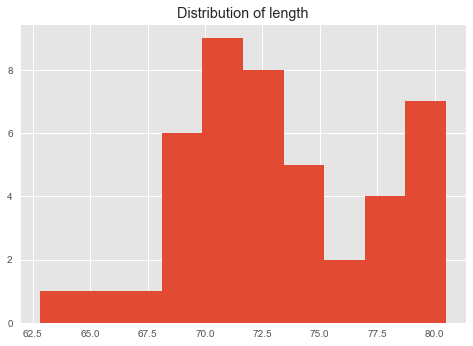

In [72]:
plt.hist(all_data.length, bins=10);
plt.title('Distribution of length');

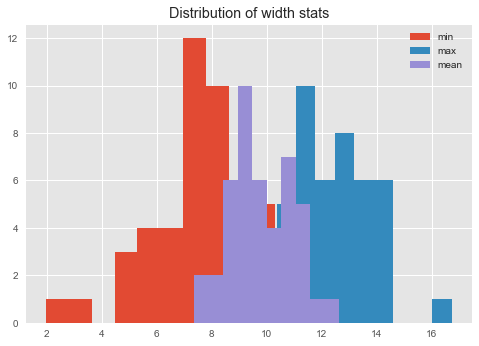

In [73]:
plt.hist(all_data.width_min, bins=10, label='min');
plt.hist(all_data.width_max, bins=10, label='max');
plt.hist(all_data.width_mean, bins=10, label='mean');
plt.title('Distribution of width stats');
plt.legend();

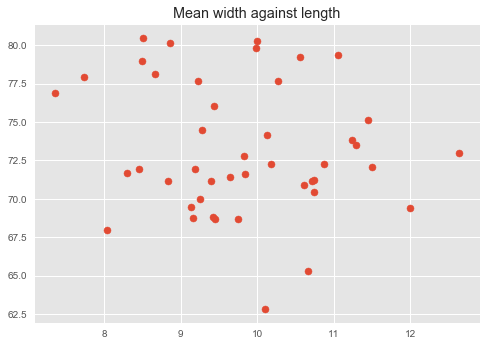

In [74]:
plt.scatter(all_data.width_mean, all_data.length);
plt.title('Mean width against length');

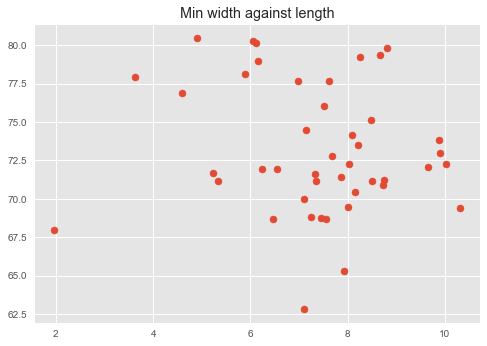

In [75]:
plt.scatter(all_data.width_min, all_data.length);
plt.title('Min width against length');

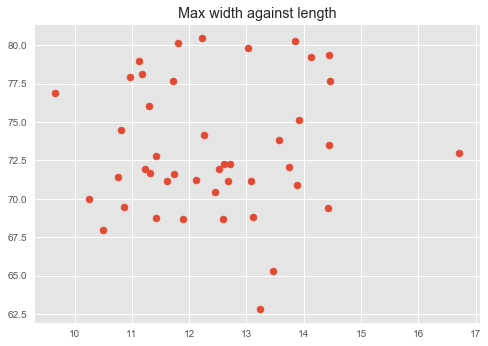

In [76]:
plt.scatter(all_data.width_max, all_data.length);
plt.title('Max width against length');

In [77]:
all_data.width_mean.quantile([0.1, 0.25, 0.5, 0.75, 0.8, 0.9])

0.10     8.464105
0.25     9.160440
0.50     9.787677
0.75    10.673161
0.80    10.735826
0.90    11.272294
Name: width_mean, dtype: float64

In [78]:
all_data.length.quantile([0.1, 0.25, 0.5, 0.75, 0.8, 0.9])

0.10    68.709298
0.25    70.795955
0.50    72.162816
0.75    77.064496
0.80    77.781023
0.90    79.350918
Name: length, dtype: float64

In [84]:
std_w = all_data.width_mean.std()
std_l = all_data.length.std()

m_w = all_data.width_mean.mean()
m_l = all_data.length.mean()

print("Std by mean for {}: {}".format("length", std_l/m_l))
print("Std by mean for {}: {}".format("width", std_w/m_w))

Std by mean for length: 0.058128589758634205
Std by mean for width: 0.11753907088324084
